# Object Detection: Object Classification and  Localization



[Presentation](https://tome.app/marcofoggetti/unlocking-the-secrets-of-object-detection-classification-and-localization-clfcu8nha2tsja542xnjiftnn)

## Goal of the analysis

The aim of the project is to develop from scratch two neural networks architectures to perform object classification and localization. 

The dataset used for classification can be found at the following link [vehicles data](https://www.kaggle.com/datasets/iamsandeepprasad/vehicle-data-set): it contains 28k images of 17 classes of vehicles. 

On the other hand, the dataset used for object localization can be accessed at the following link [car dataset](https://www.kaggle.com/datasets/andrewteplov/car-data) and contains 6458 images of cars with annotations for the bounding box in format x1, y1, x2, y2 corresponding to the top-left and bottom-right corners. 

# Vehicles Classification





## Libraries
Here we import the necessary libraries.

In [ ]:
# modules for importing
from pathlib import Path
import os.path
import pandas as pd
import numpy as np

# modules for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import random
from PIL import Image

# modules of Py-Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

# modules for metrics
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

## Data Exploration

This Dataset contains 28k images of 17 different class of vehicles:

* Ambulance
* Barge
* Bicycle
* Boat
* Bus
* Car
* Cart
* Caterpillar
* Helicopter
* Limousine
* Motorcycle
* Segway
* Snowmobile
* Tank
* Taxi
* Truck
* Van


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/University/DAB/Deep Learning/Project/vehicles_data'

/content/drive/MyDrive/University/DAB/Deep Learning/Project/vehicles_data


Here, the code iterates through each vehicle folder in the train and test folders using the os library to get the file paths for each image file in the folders, and appends the file path and label to the data list.

After collecting all the data, a pandas DataFrame object is created from the data list with columns 'Filepath' and 'Label',

In [ ]:
# Define the paths to the train and test folders
train_folder = '/content/drive/MyDrive/University/DAB/Deep Learning/Project/vehicles_data/train'
test_folder = '/content/drive/MyDrive/University/DAB/Deep Learning/Project/vehicles_data/test'

# Initialize an empty list to store the file paths and labels
data = []

# Iterate through each vehicle folder in the train folder
for label in os.listdir(train_folder):
    vehicle_folder = os.path.join(train_folder, label)
    
    # Iterate through each file in the vehicle folder
    for filename in os.listdir(vehicle_folder):
        # Construct the file path
        filepath = os.path.join(vehicle_folder, filename)
        
        # Append the file path and label to the data list
        data.append((filepath, label))

# Iterate through each vehicle folder in the test folder
for label in os.listdir(test_folder):
    vehicle_folder = os.path.join(test_folder, label)
    
    # Iterate through each file in the vehicle folder
    for filename in os.listdir(vehicle_folder):
        # Construct the file path
        filepath = os.path.join(vehicle_folder, filename)
        
        # Append the file path and label to the data list
        data.append((filepath, label))

# Create a DataFrame object from the data list
df = pd.DataFrame(data, columns=['Filepath', 'Label'])

# Print the first 5 rows of the DataFrame
print(df.head())


                                            Filepath Label
0  /content/drive/MyDrive/University/DAB/Deep Lea...  Tank
1  /content/drive/MyDrive/University/DAB/Deep Lea...  Tank
2  /content/drive/MyDrive/University/DAB/Deep Lea...  Tank
3  /content/drive/MyDrive/University/DAB/Deep Lea...  Tank
4  /content/drive/MyDrive/University/DAB/Deep Lea...  Tank


When conducting a classification task, it is important to assess the representation of the categories being predicted to prevent any potential bias in the model's predictions. 

In [ ]:
class_counts = df['Label'].value_counts()
class_counts

Boat           8846
Car            6871
Motorcycle     3009
Bus            2133
Truck          2033
Bicycle        1779
Van            1115
Taxi            748
Helicopter      678
Caterpillar     331
Tank            206
Barge           202
Segway          153
Ambulance       132
Snowmobile      123
Limousine        74
Cart             51
Name: Label, dtype: int64

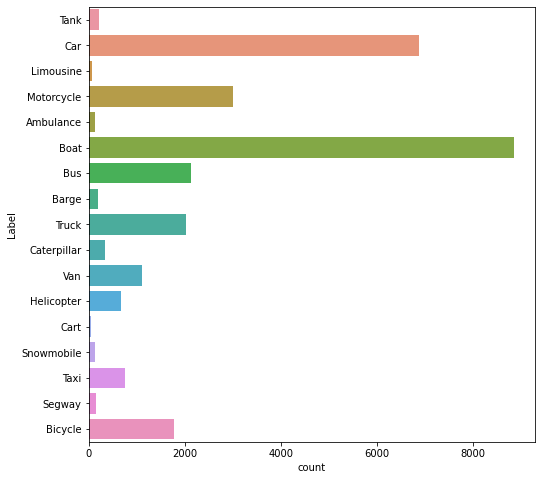

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(y='Label', data=df)
plt.show()

As shown, the dataset seems to be really unbalanced. Some of the classes are overrapresented, and others are underrapresented. 

To ensure a uniform representation of all classes, those containing less than 400 images are filtered out, while those containing more than 400 images are reduced to 400 images per class.

In [ ]:
# Filter out the classes with less than 400 images
df = df[df['Label'].isin(class_counts.index[class_counts >= 400])]

The final number of classes retained is 9 and they are:
* Boat
* Car
* Motorcycle
* Bus
* Truck
* Bicycle
* Van
* Taxi
* Helicopter

In [ ]:
df['Label'].value_counts()

Boat          8846
Car           6871
Motorcycle    3009
Bus           2133
Truck         2033
Bicycle       1779
Van           1115
Taxi           748
Helicopter     678
Name: Label, dtype: int64

Here, the number of images per class is reduced to 400. 

In [ ]:
# Define the maximum number of images per class
MAX_IMAGES_PER_CLASS = 400

# Group the DataFrame by label and count the number of images per class
grouped = df.groupby('Label').count()
grouped = grouped.rename(columns={'Filepath': 'counts'})

# Iterate through each class with more than MAX_IMAGES_PER_CLASS images
for label, count in grouped[grouped['counts'] > MAX_IMAGES_PER_CLASS].iterrows():
    # Get the indices of all images for this class
    indices = df[df['Label'] == label].index.tolist()
    
    # Randomly shuffle the indices
    random.shuffle(indices)
    
    # Delete all but MAX_IMAGES_PER_CLASS indices
    indices_to_delete = indices[MAX_IMAGES_PER_CLASS:]
    df = df.drop(indices_to_delete)
    
# Print the updated DataFrame
print(df.head())


                                              Filepath Label
135  /content/drive/MyDrive/University/DAB/Deep Lea...   Car
151  /content/drive/MyDrive/University/DAB/Deep Lea...   Car
168  /content/drive/MyDrive/University/DAB/Deep Lea...   Car
177  /content/drive/MyDrive/University/DAB/Deep Lea...   Car
196  /content/drive/MyDrive/University/DAB/Deep Lea...   Car


In [ ]:
df['Label'].value_counts()

Car           400
Motorcycle    400
Boat          400
Bus           400
Truck         400
Van           400
Helicopter    400
Taxi          400
Bicycle       400
Name: Label, dtype: int64

In [ ]:
df.reset_index(drop=True, inplace=True)
print(df.head())

                                            Filepath Label
0  /content/drive/MyDrive/University/DAB/Deep Lea...   Car
1  /content/drive/MyDrive/University/DAB/Deep Lea...   Car
2  /content/drive/MyDrive/University/DAB/Deep Lea...   Car
3  /content/drive/MyDrive/University/DAB/Deep Lea...   Car
4  /content/drive/MyDrive/University/DAB/Deep Lea...   Car


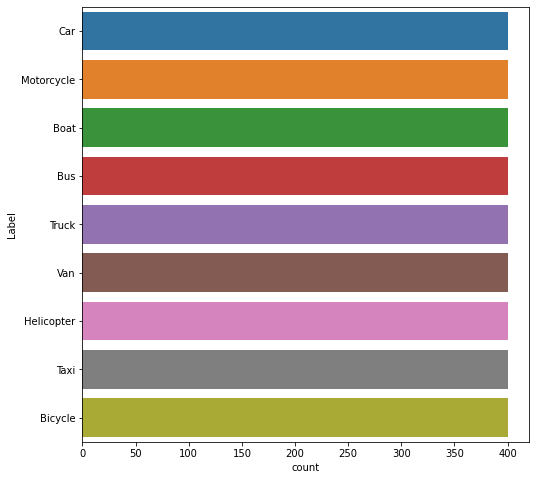

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(y='Label', data=df)
plt.show()

All classes are now equally represented, and a random sample can be selected and shown.





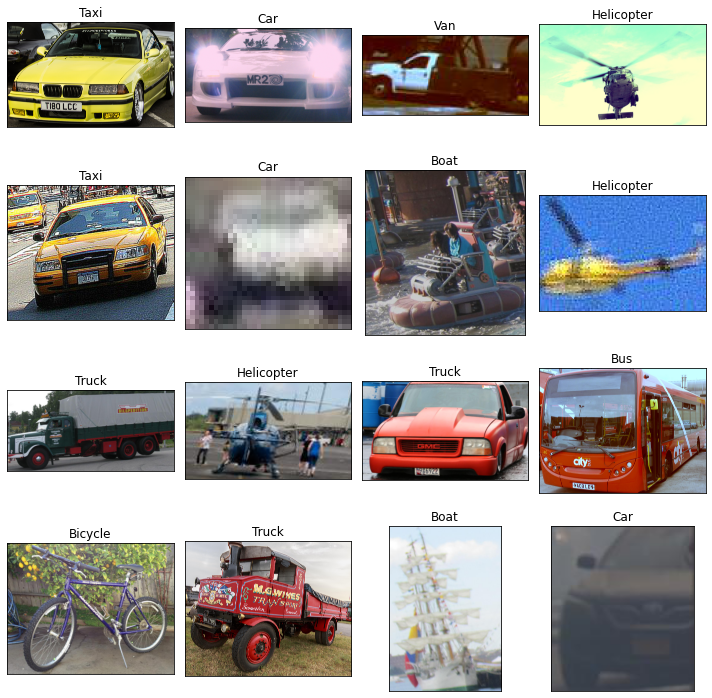

In [ ]:
# randomly select 16 images

random.seed(10)
selected_images = random.sample(list(df['Filepath']), 16)

# plot the selected images
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img_path = selected_images[i]
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(df[df['Filepath']==img_path]['Label'].values[0])
plt.tight_layout()
plt.show()

The images exhibit significant variations in terms of their size, angle of view, coloration, and some are even blurred

## PyTorch Dataset Class

First of all a **custom PyTorch dataset** can be created by subclassing the *torch.utils.data.Dataset* class:

In [ ]:
class VehicleDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.label_map = {
            "Bicycle": 0,
            "Boat": 1,
            "Bus": 2,
            "Car": 3,
            "Helicopter": 4,
            "Motorcycle": 5,
            "Taxi": 6,
            "Truck": 7,
            "Van": 8
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        filepath = self.df.iloc[index]['Filepath']
        label_str = self.df.iloc[index]['Label']
        label = self.label_map[label_str]
        image = Image.open(filepath).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)


To enhance the neural network's training performance, certain **transformations** are applied to the dataset. Given the considerable variation among the images, only those transformations related to their standardization are used.


The **Resize** and **CenterCrop** operations help to standardize the size and aspect ratio of the input images, while the ToTensor operation converts the image into a format that can be processed by a neural network. The **normalization** step also helps to ensure that the input data has a similar scale across all the three color channels (RGB), which can improve the performance of the neural network during training.

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Here an instance of the custom dataset is created and the transformations are applied.

In [ ]:
dataset = VehicleDataset(df, transform=transform)

Here an example of what the `__getitem__ `method looks like is presented. 

It can be evidenced that the shape of the image tensor is (3, height, width), where height and width are both 256 meanwhile 3 represents the number of channels in the image given the transformation to a 3-channel RGB image. 

In [ ]:
dataset.__getitem__(0)

(tensor([[[-0.5596, -0.1999,  0.0056,  ..., -1.9467, -1.9295, -1.9295],
          [ 0.4679,  0.6906,  0.6734,  ..., -2.0494, -2.0323, -2.0152],
          [ 0.6734,  0.9817,  1.0844,  ..., -2.0837, -2.0837, -2.0837],
          ...,
          [ 0.6392,  1.3413,  1.4098,  ..., -0.0972, -0.0801, -0.1657],
          [ 1.2043,  1.4612,  1.3927,  ..., -0.4226, -0.3712, -0.2856],
          [ 1.2385,  1.6324,  1.5125,  ..., -0.2513, -0.3198, -0.4054]],
 
         [[-0.8452, -0.5651, -0.4251,  ..., -1.8431, -1.8256, -1.8256],
          [ 0.0126,  0.1877,  0.1176,  ..., -1.9482, -1.9307, -1.9132],
          [ 0.1176,  0.4328,  0.5028,  ..., -1.9832, -1.9832, -1.9832],
          ...,
          [ 0.4678,  1.1506,  1.1331,  ..., -0.2850, -0.2325, -0.2850],
          [ 0.9755,  1.2731,  1.1856,  ..., -0.5126, -0.4776, -0.3901],
          [ 1.0455,  1.4832,  1.3081,  ..., -0.4251, -0.4076, -0.4426]],
 
         [[-0.9853, -0.7761, -0.6715,  ..., -1.5256, -1.4907, -1.4733],
          [-0.3055, -0.1661,

## Train, Validation and Test Data splitting

To avoid overfitting, the data is split into three sets: train, validation, and test. 

The train set is used to train the model, the validation set is used to tune the hyperparameters, and the test set is used to evaluate the final performance of the model on unseen data.

Finally, the dataset is splitted into train/validation/test sets using the *torch.utils.data.random_split* function using a 70-15-15 split, where 70% of the data is used for training, 15% for validation, and 15% for testing.

In [ ]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

torch.manual_seed(10)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])


Finally, **PyTorch dataloaders** are created for each dataset:

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## AlexNet 

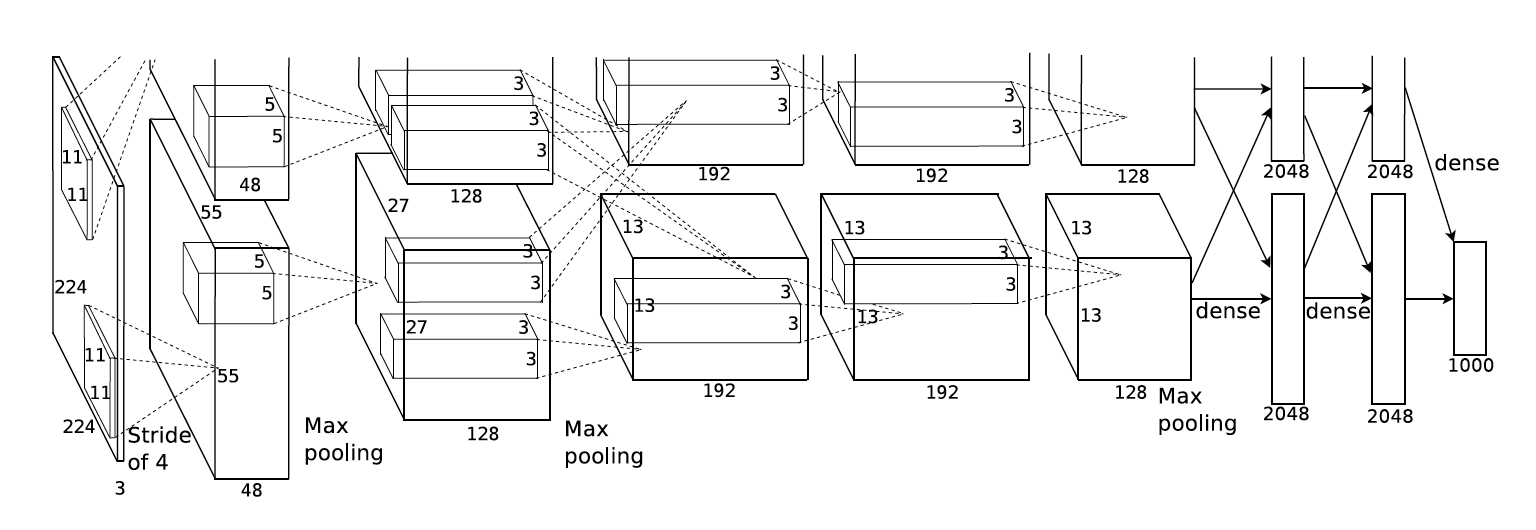

The AlexNet architecture consists of five convolutional layers, followed by three fully connected layers, with a final softmax layer for classification. The convolutional layers use small filter sizes (3x3 and 5x5) with a stride of 1 or 2 and are followed by max pooling layers. The activation function used in the network is the rectified linear unit (ReLU), which has been shown to improve the training of deep neural networks.




While the backbone of the network proposed is the same as the original AlexNet, there are a few differences in the implementation: 


* **Batch normalization** after each convolutional layer. Batch normalization helps to normalize the activations of the previous layer and can improve the stability and speed of training.

* **Adaptive Average Pooling**: Adaptive average pooling allows the network to handle input images of different sizes by automatically adapting the output size of the pooling layer. Even if the images are resized to the same size, adaptive average pooling may still be beneficial. Having multiple convolutional layers, using adaptive average pooling before the fully connected layers can help to reduce the number of parameters and improve the computational efficiency of the model.

* **Classification layers**: the classification layers consist of an adaptive average pooling layer, which pools the feature maps down to a fixed size, followed by two fully connected layers with dropout regularization; the final layer has a number of outputs equal to the number of classes in the dataset.

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=9):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


## Cross Entropy Loss
The cross-entropy loss is a commonly used loss function in machine learning, especially in classification tasks. It measures the difference between the predicted probability distribution and the true probability distribution.
\begin{equation}
    \operatorname{L}(\boldsymbol{y}, \boldsymbol{\hat{y}}) = -\sum_{i} y_i \log \hat{y_i}\
\end{equation}

where $\boldsymbol{y}$ is the true probability distribution (a one-hot encoded vector) and $\boldsymbol{\hat{y}}$ is the predicted probability distribution (also a vector). The $\log$ function is used to emphasize the difference between the two probability distributions. The negative sign is added to convert the minimization problem to a maximization problem.




## HyperParameters
* Learning Rate = 0.00001
* Batch Size = 32
* Epochs = 15
* Optimizer = Adam Optimizer

In [ ]:
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
EPOCHS = 20
device = "cuda" if torch.cuda.is_available() else "cpu"

alexnet = AlexNet() #  On CPU
alexnet.to(device) # On GPU
criterion = nn.CrossEntropyLoss() # Specify the loss criteria
optimizer = optim.Adam(alexnet.parameters(), lr=LEARNING_RATE) # Use an "Adam" optimizer to adjust weights

train_accuracy= []
train_loss= []
valid_accuracy=[]
valid_loss=[]
best_valid_loss = float('inf')
epochs_without_improvement = 0
patience = 3 # how many epochs to wait for improvement

for epoch in tqdm(range(EPOCHS)):
    print("Epoch {} ".format(epoch))
    num_correct = 0
    num_samples = 0
    running_loss = 0
    # Set the model to training mode
    alexnet.train()
    with tqdm(total=len(train_loader)) as pbar:
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device=device)
            targets = targets.to(device=device)
                
            # Reset the optimizer
            optimizer.zero_grad()

            scores = alexnet(data)
            _, predictions = scores.max(1)

            # Get the loss
            loss = criterion(scores, targets)
            running_loss += loss.item()

            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)

            # backpropagation
            loss.backward()
            optimizer.step()
            pbar.update(1)
    print("Correct: {}, Total: {}, Train Accuracy: {}, Train Loss:{}".format(num_correct, num_samples, int(num_correct) / int(num_samples),running_loss/len(train_loader)))
    train_accuracy.append(int(num_correct) / int(num_samples))
    train_loss.append(running_loss/len(train_loader))

    num_correct_valid = 0
    num_samples_valid = 0
    batch_loss = 0
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    alexnet.eval()
    with torch.no_grad():
        for data_, targets_ in tqdm(val_loader):
            data_ = data_.to(device)
            targets_ = targets_.to(device)
            scores_ = alexnet(data_)
            _, predictions_ = scores_.max(1)

            loss_valid = criterion(scores_, targets_)
            batch_loss += loss_valid.item()
            num_correct_valid += (predictions_ == targets_).sum()
            num_samples_valid += predictions_.size(0)
        print("Correct: {}, Total: {}, Valid Accuracy: {}, Valid Loss:{}".format(num_correct_valid, num_samples_valid, int(num_correct_valid) / int(num_samples_valid),batch_loss/len(val_loader)))
        valid_accuracy.append(int(num_correct_valid) / int(num_samples_valid))
        valid_loss.append(batch_loss/len(val_loader))

        #Early stopping
        # Check if the validation loss has improved. If not, increase the number of epochs without improvement
        if batch_loss/len(val_loader) < best_valid_loss:
            best_valid_loss = batch_loss/len(val_loader)
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            # If the number of epochs without improvement has reached the patience limit, stop training
            if epochs_without_improvement == patience:
                print("Early stopping at epoch {}".format(epoch))
                break


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 


  0%|          | 0/79 [00:00<?, ?it/s]

Correct: 459, Total: 2520, Train Accuracy: 0.18214285714285713, Train Loss:2.184277840807468


  0%|          | 0/17 [00:00<?, ?it/s]

Correct: 203, Total: 540, Valid Accuracy: 0.37592592592592594, Valid Loss:1.8959006000967586
Epoch 1 


  0%|          | 0/79 [00:00<?, ?it/s]

Correct: 779, Total: 2520, Train Accuracy: 0.30912698412698414, Train Loss:1.8985647008388857


  0%|          | 0/17 [00:00<?, ?it/s]

Correct: 238, Total: 540, Valid Accuracy: 0.44074074074074077, Valid Loss:1.7168088520274443
Epoch 2 


  0%|          | 0/79 [00:00<?, ?it/s]

Correct: 937, Total: 2520, Train Accuracy: 0.37182539682539684, Train Loss:1.740839633760573


  0%|          | 0/17 [00:00<?, ?it/s]

Correct: 239, Total: 540, Valid Accuracy: 0.4425925925925926, Valid Loss:1.6096351637559778
Epoch 3 


  0%|          | 0/79 [00:00<?, ?it/s]

Correct: 1131, Total: 2520, Train Accuracy: 0.4488095238095238, Train Loss:1.5881952152976506


  0%|          | 0/17 [00:00<?, ?it/s]

Correct: 260, Total: 540, Valid Accuracy: 0.48148148148148145, Valid Loss:1.4897503291859346
Epoch 4 


  0%|          | 0/79 [00:00<?, ?it/s]

Correct: 1198, Total: 2520, Train Accuracy: 0.4753968253968254, Train Loss:1.4780930914456332


  0%|          | 0/17 [00:00<?, ?it/s]

Correct: 267, Total: 540, Valid Accuracy: 0.49444444444444446, Valid Loss:1.4340934052186853
Epoch 5 


  0%|          | 0/79 [00:00<?, ?it/s]

Correct: 1320, Total: 2520, Train Accuracy: 0.5238095238095238, Train Loss:1.3896341218224055


  0%|          | 0/17 [00:00<?, ?it/s]

Correct: 284, Total: 540, Valid Accuracy: 0.5259259259259259, Valid Loss:1.364284774836372
Epoch 6 


  0%|          | 0/79 [00:00<?, ?it/s]

Correct: 1353, Total: 2520, Train Accuracy: 0.5369047619047619, Train Loss:1.3090492781204512


  0%|          | 0/17 [00:00<?, ?it/s]

Correct: 295, Total: 540, Valid Accuracy: 0.5462962962962963, Valid Loss:1.3428361766478594
Epoch 7 


  0%|          | 0/79 [00:00<?, ?it/s]

Correct: 1420, Total: 2520, Train Accuracy: 0.5634920634920635, Train Loss:1.2351607325710827


  0%|          | 0/17 [00:00<?, ?it/s]

Correct: 299, Total: 540, Valid Accuracy: 0.5537037037037037, Valid Loss:1.316403115496916
Epoch 8 


  0%|          | 0/79 [00:00<?, ?it/s]

Correct: 1473, Total: 2520, Train Accuracy: 0.5845238095238096, Train Loss:1.1621233096605614


  0%|          | 0/17 [00:00<?, ?it/s]

Correct: 296, Total: 540, Valid Accuracy: 0.5481481481481482, Valid Loss:1.301532647188972
Epoch 9 


  0%|          | 0/79 [00:00<?, ?it/s]

Correct: 1527, Total: 2520, Train Accuracy: 0.6059523809523809, Train Loss:1.1188667861721184


  0%|          | 0/17 [00:00<?, ?it/s]

Correct: 303, Total: 540, Valid Accuracy: 0.5611111111111111, Valid Loss:1.2637347053079044
Epoch 10 


  0%|          | 0/79 [00:00<?, ?it/s]

Correct: 1573, Total: 2520, Train Accuracy: 0.6242063492063492, Train Loss:1.0836770851400834


  0%|          | 0/17 [00:00<?, ?it/s]

Correct: 313, Total: 540, Valid Accuracy: 0.5796296296296296, Valid Loss:1.2135447263717651
Epoch 11 


  0%|          | 0/79 [00:00<?, ?it/s]

Correct: 1611, Total: 2520, Train Accuracy: 0.6392857142857142, Train Loss:1.0183230895030349


  0%|          | 0/17 [00:00<?, ?it/s]

Correct: 317, Total: 540, Valid Accuracy: 0.587037037037037, Valid Loss:1.200490117073059
Epoch 12 


  0%|          | 0/79 [00:00<?, ?it/s]

Correct: 1686, Total: 2520, Train Accuracy: 0.669047619047619, Train Loss:0.9475248342827906


  0%|          | 0/17 [00:00<?, ?it/s]

Correct: 293, Total: 540, Valid Accuracy: 0.5425925925925926, Valid Loss:1.2814231409746057
Epoch 13 


  0%|          | 0/79 [00:00<?, ?it/s]

Correct: 1765, Total: 2520, Train Accuracy: 0.7003968253968254, Train Loss:0.8843257517754277


  0%|          | 0/17 [00:00<?, ?it/s]

Correct: 329, Total: 540, Valid Accuracy: 0.6092592592592593, Valid Loss:1.183018684387207
Epoch 14 


  0%|          | 0/79 [00:00<?, ?it/s]

Correct: 1816, Total: 2520, Train Accuracy: 0.7206349206349206, Train Loss:0.8450335777258571


  0%|          | 0/17 [00:00<?, ?it/s]

Correct: 308, Total: 540, Valid Accuracy: 0.5703703703703704, Valid Loss:1.2310212499955122
Epoch 15 


  0%|          | 0/79 [00:00<?, ?it/s]

Correct: 1812, Total: 2520, Train Accuracy: 0.719047619047619, Train Loss:0.8142415707624411


  0%|          | 0/17 [00:00<?, ?it/s]

Correct: 331, Total: 540, Valid Accuracy: 0.6129629629629629, Valid Loss:1.2162668003755457
Epoch 16 


  0%|          | 0/79 [00:00<?, ?it/s]

Correct: 1851, Total: 2520, Train Accuracy: 0.7345238095238096, Train Loss:0.7718004203295405


  0%|          | 0/17 [00:00<?, ?it/s]

Correct: 308, Total: 540, Valid Accuracy: 0.5703703703703704, Valid Loss:1.2787868976593018
Early stopping at epoch 16


During the training phase, it can be observed that the model's performance is getting better with each epoch. This is evidenced by the reduction in the train and validation losses and the rise in the train and validation accuracy. 

To avoid overfitting due to lack of improvement in the loss function for three consecutive epochs, the training process is stopped by an early stopping at the 16th epoch.





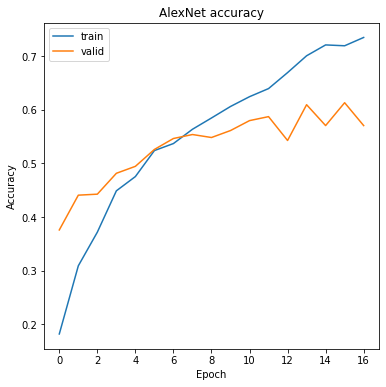

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(train_accuracy)
plt.plot(valid_accuracy)
plt.title('AlexNet accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
plt.savefig('AlexNet_Accuracy.png')

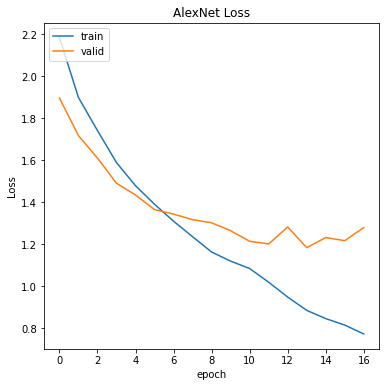

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(train_loss)
plt.plot(valid_loss)
plt.title('AlexNet Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
plt.savefig('Alexnet_Loss.png')

In [ ]:
"""

# save the model
torch.save({
            'epoch': epoch,
            'model_state_dict': alexnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_accuracy': train_accuracy,
            'train_loss': train_loss,
            'valid_accuracy': valid_accuracy,
            'valid_loss': valid_loss,
            'best_valid_loss': best_valid_loss
            }, 'model.pth')
# load the model
checkpoint = torch.load('model.pth')
alexnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_accuracy = checkpoint['train_accuracy']
train_loss = checkpoint['train_loss']
valid_accuracy = checkpoint['valid_accuracy']
valid_loss = checkpoint['valid_loss']
best_valid_loss = checkpoint['best_valid_loss']

"""

## Prediction
Here the aim is to assess the accuracy of the model's predictions on the test dataset, which was not utilized during either the training or validation phases. This approach allows to evaluate the model's ability to perform well on new and unseen data, and determine its overall effectiveness in solving the intended problem.

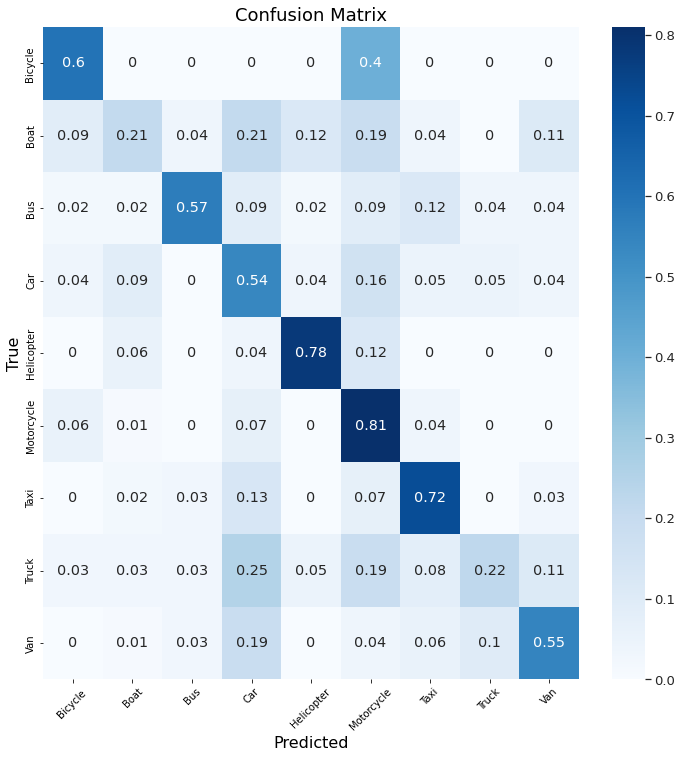

In [ ]:
y_pred = []
y_true = []
# iterate over test data
for inputs, labels in test_loader:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        inputs, labels = inputs.to(device), labels.to(device)
        output = alexnet(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
      
# classes
classes = ('Bicycle ', 'Boat', 'Bus', 'Car', 'Helicopter', 'Motorcycle', 'Taxi', 'Truck', 'Van')

# Get the confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Get the percentages
cf_matrix = np.round(cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis], 2)

# Create a heatmap
fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.2) # adjust font size
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
ax.set_xticklabels(classes, rotation=45)

# Add labels and title
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)

# Show the plot
plt.show()


# Object Detection

**Object Detection** is a fundamental task in computer vision that involves identifying and localizing  objects within an image or video. It plays a crucial role in a wide range of applications, from autonomous vehicles and robotics to security systems.

In this section, we will be implementing and fine-tuning a **ResNet50** neural network from scratch to perform object localization for cars in an image. 

ResNet, short for "Residual Network," is a deep neural network architecture that was introduced by Microsoft researchers in 2015. 

The main innovation of ResNet is the use of residual connections, which allow the network to be much deeper than previous architectures. A residual connection is a shortcut connection that skips one or more layers of the network, allowing the gradient to be directly propagated through the network. This helps to alleviate the problem of vanishing gradients, which can occur when a network is too deep and the gradients become too small to be propagated effectively through the layers. 

## Libraries
Here the necessary libraries are imported again.

In [ ]:
import os, sys
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image

In [ ]:
%cd '/content/drive/MyDrive/University/DAB/Deep Learning/Project/car_data'

/content/drive/MyDrive/University/DAB/Deep Learning/Project/car_data


## Dataset and annotations

With the os library a variable pointing to the path of the folder where the images are stored is instatiated. 

In [ ]:
images_dir = os.path.join(os.getcwd(), 'images/')
images_dir

'/content/drive/MyDrive/University/DAB/Deep Learning/Project/car_data/images/'

At this point, through the Pandas library, the DataFrame containing the annotations for the bounding boxes is loaded in format x1, y1, x2, y2, which are the coordinates for the top-left and bottom-right corners. 

In [ ]:
df= pd.read_csv('images_w_boxes.csv')
df.head()

,img_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,bd3138e00c925841a3934f3075f9c734.jpg,412,28,745,185
1,7b9bf41480eafc0c11d2e56502a93b45.jpg,250,229,860,634
2,ca56229ef626d9e0e24a496c5e490018.jpg,361,231,966,628
3,308f316edd39e74f7636fc8a40eeb712.jpg,151,230,925,655
4,bc7b5c4b60a7bcd4e477755b64c69b34.jpg,35,219,939,657


As already mentioned, the dataset contains 6458 images but for training purposes we decided to reduce the dimension to 2000 instances. 

In [ ]:
df = df.sample(n = 2000, replace = False, random_state = 10)
df = df.reset_index(drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_path  2000 non-null   object
 1   bbox_x1   2000 non-null   int64 
 2   bbox_y1   2000 non-null   int64 
 3   bbox_x2   2000 non-null   int64 
 4   bbox_y2   2000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 78.2+ KB


Here an image example with the ground truth bounding box around the car is presented. 

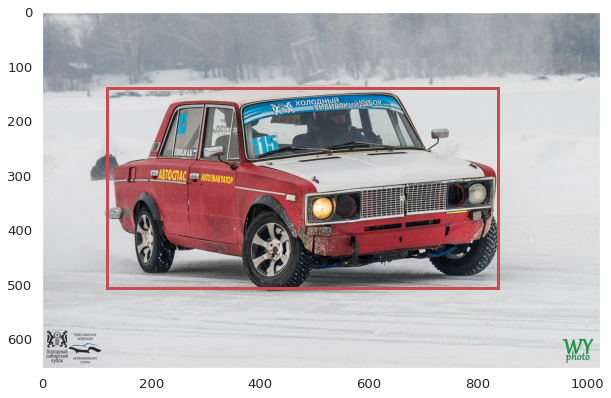

In [ ]:
# Load the image
i = 500 #random
image_id = df.iloc[i]['img_path']
image = Image.open(images_dir + image_id)
#image = Image.open(images_dir + df['img_path'][i])


# Create a figure and axes
fig, ax = plt.subplots(1, figsize = (10,10))

# Show the image
ax.imshow(image)

x1 = df.iloc[i]['bbox_x1']
x2 = df.iloc[i]['bbox_x2']
y1 = df.iloc[i]['bbox_y1']
y2 = df.iloc[i]['bbox_y2']

# Create a rectangle patch
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor='r', facecolor='none')

# Add the patch to the axes
ax.add_patch(rect)
ax.grid(False)
plt.show()

### PyTorch Dataset Class

The PyTorch Dataset class is a abstract class in PyTorch used to represent a dataset and it is a fundamental component in PyTorch for loading and working with custom data in machine learning models.

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`.

The `__len__ ` method is used to return the number of samples in the dataset, and is called by the PyTorch dataloader to determine the length of the dataset.

The `__getitem__ `method is instead used to return a single sample from the dataset, given an index. It takes an index as input, and returns a tuple containing the sample data and its corresponding label.

In [ ]:
class CarDataset(object):
    def __init__(self, df, images_dir, transforms=None, bbox_transforms=None):
        self.df = df
        self.images_dir = images_dir
        self.image_ids = self.df['img_path'].tolist()
        self.transforms = transforms
        self.bbox_transforms = bbox_transforms
        
    def __len__(self):
        return len(self.image_ids)
        
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img = Image.open(self.images_dir + image_id).convert('RGB')
        bbox = self.df.loc[idx, ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values.astype(float)

        width, height = img.size
        
        if self.transforms:
            img = self.transforms(img)
        
        if self.bbox_transforms:
            bbox = self.bbox_transforms(bbox, (width, height), (224,224))
        

        bbox = torch.tensor(bbox)
        

        return img, bbox


Here two **transformation** functions are defined to be applied to our input images and bounding boxes.

The `img_transform `function resizes the image to 224x224 pixels and converts it to a PyTorch tensor.

The `bbox_transforms` function resizes the bounding box coordinates based on the original and resized image sizes. 

Resizing the images allows us to standardize their dimensions and reduce the computational complexity of the model, while resizing the bounding boxes ensures that they continue to accurately identify the location of the objects of interest even after the image size has changed.

In [ ]:
#Image Transformation
img_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])


#Bounding Box transformation
def bbox_transforms(box, original_size, resized_size):
    """
    Resizes bounding box coordinates based on the original and resized image sizes.

    Args:
        box (numpy.ndarray): Bounding box coordinates in the format ["x1", "y1", "x2", "y2"].
        original_size (tuple): Original image size in the format (width, height).
        resized_size (tuple): Resized image size in the format (width, height).

    Returns:
        boxes_resized: Resized bounding box coordinates in the format ["x1", "y1", "x2", "y2"].
    """
    scale_x = resized_size[0] / original_size[0]
    scale_y = resized_size[1] / original_size[1]
    
    
    box_resized = box
    box_resized[0] *= scale_x
    box_resized[2] *= scale_x
    box_resized[1] *= scale_y
    box_resized[3] *= scale_y


    return box_resized

This is an example of what the `__getitem__ `method looks like. 
It can be noticed again that the shape of the image tensor is (3, height, width), where height and width are both 224 meanwhile 3 represents the number of channels in the image given the transformation to a 3-channel RGB image. 

In [ ]:
cardata = CarDataset(df, images_dir, transforms =img_transform, bbox_transforms = bbox_transforms)
print(cardata.__getitem__(6)[0].shape)
cardata.__getitem__(6)

torch.Size([3, 224, 224])


(tensor([[[0.5333, 0.5294, 0.5255,  ..., 0.5804, 0.5725, 0.5765],
          [0.5373, 0.5294, 0.5255,  ..., 0.5804, 0.5765, 0.5725],
          [0.5412, 0.5373, 0.5373,  ..., 0.5843, 0.5765, 0.5804],
          ...,
          [0.6039, 0.6235, 0.6039,  ..., 0.7529, 0.7490, 0.7412],
          [0.6314, 0.6392, 0.6157,  ..., 0.7412, 0.7490, 0.7490],
          [0.6392, 0.6471, 0.6392,  ..., 0.7333, 0.7412, 0.7373]],
 
         [[0.7451, 0.7451, 0.7451,  ..., 0.8000, 0.7922, 0.7961],
          [0.7451, 0.7451, 0.7451,  ..., 0.8000, 0.7961, 0.7922],
          [0.7451, 0.7490, 0.7529,  ..., 0.8039, 0.7961, 0.8000],
          ...,
          [0.5686, 0.5882, 0.5686,  ..., 0.7373, 0.7333, 0.7255],
          [0.6039, 0.6078, 0.5882,  ..., 0.7255, 0.7333, 0.7333],
          [0.6157, 0.6235, 0.6157,  ..., 0.7176, 0.7255, 0.7216]],
 
         [[0.9647, 0.9647, 0.9608,  ..., 1.0000, 0.9922, 0.9961],
          [0.9647, 0.9647, 0.9647,  ..., 0.9961, 0.9922, 0.9882],
          [0.9686, 0.9686, 0.9725,  ...,

## Train, Validation and Test Data splitting

The data is randomly split into three sets using a 70-15-15 split, where 70% of the data is used for training, 15% for validation, and 15% for testing through the PyTorch's random_split function. 

In [ ]:
lengths = [int(cardata.__len__() * i) for i in [0.7, 0.15, 0.15]]
lengths

[1400, 300, 300]

In [ ]:
torch.manual_seed(10)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(cardata, lengths)

### PyTorch DataLoader

The dataloaders are fundamental as they take as input a dataset object and various parameters such as the batch size and number of workers, and returns an iterable object that provides batches of data to the model during training.

In [ ]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2
)


valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

## Neural Network Architecture: ResNet50
The ResNet architecture is considered to be among the most popular Convolutional Neural Network architectures around. 


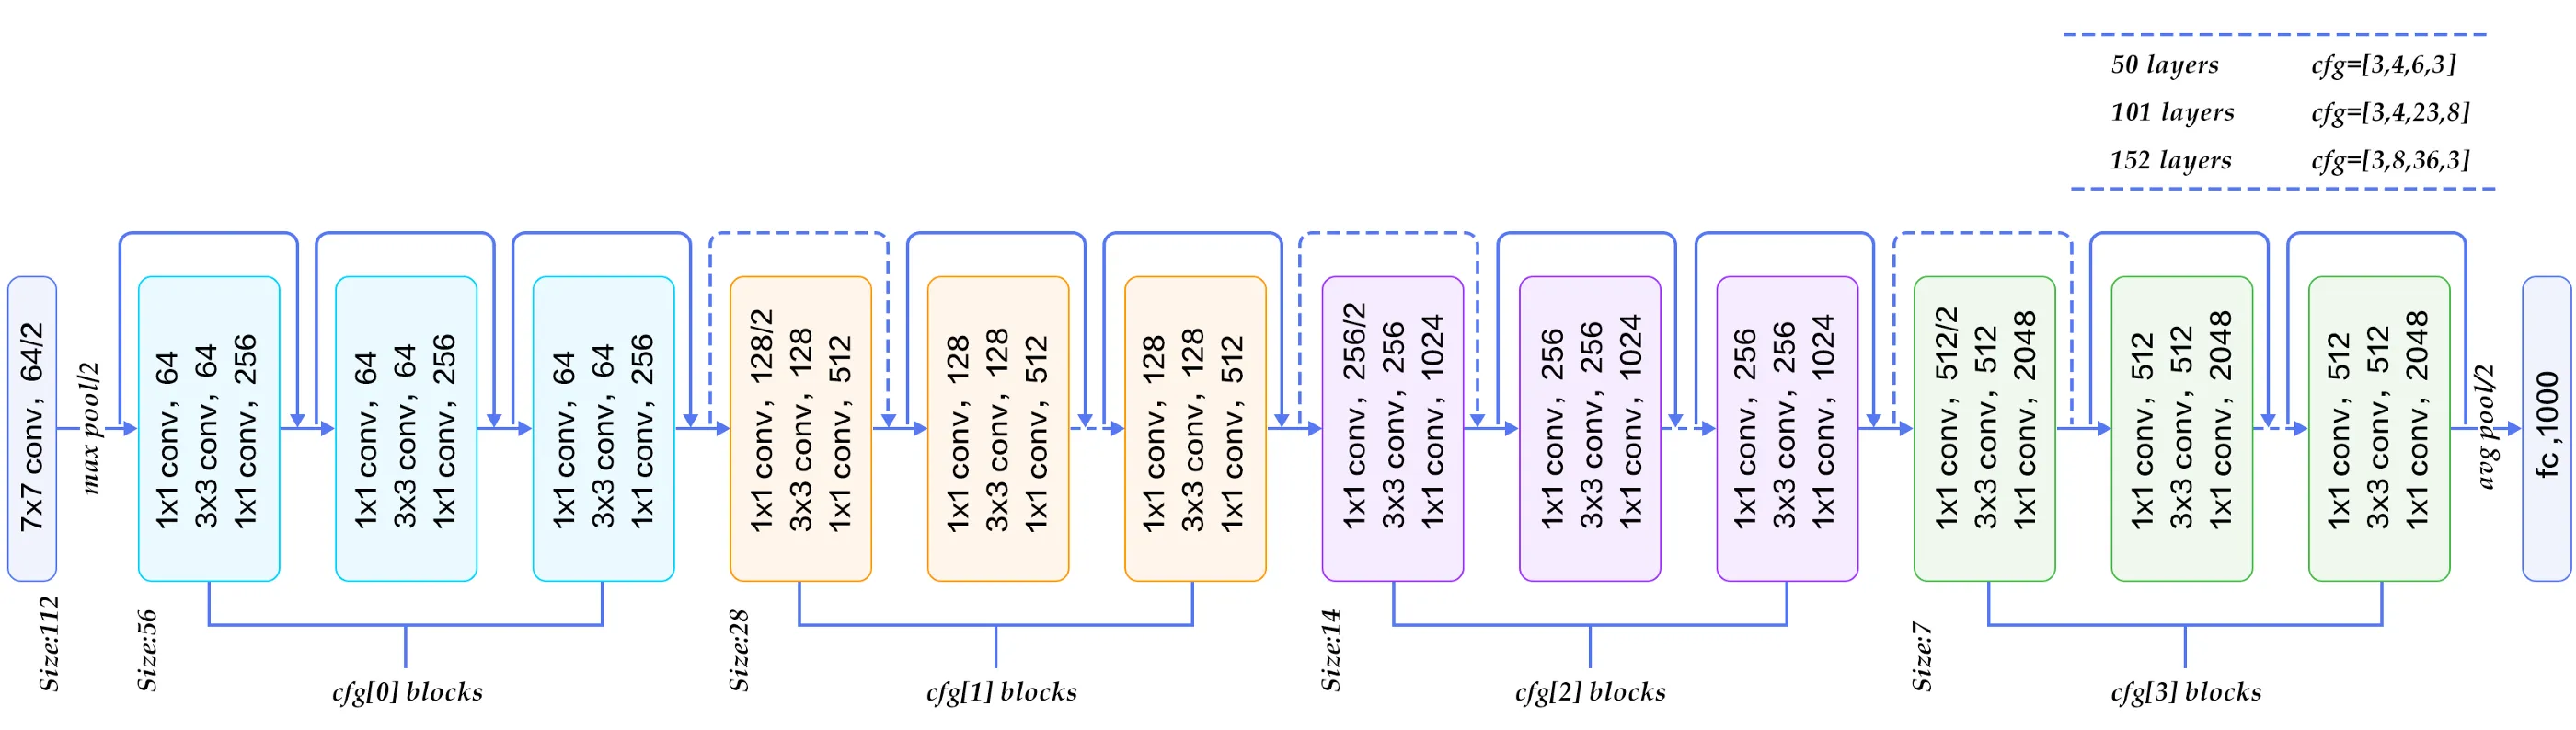

The ResNet50 architecture begins with a convolutional layer with 64 filters, a kernel size of 7x7, and a stride of 2. This layer is followed by batch normalization and a ReLU activation function. A max pooling layer with a kernel size of 3x3 and a stride of 2 is then applied to the output of the first convolutional layer.

After the max pooling layer, the ResNet50 architecture contains four residual blocks, each containing several convolutional layers, batch normalization, and ReLU activation functions. The first residual block has 3 convolutional layers with 64, 64, and 256 filters, respectively. The subsequent residual blocks have 4, 6, and 3 convolutional layers, respectively, with increasing numbers of filters.

After the residual blocks, the ResNet50 architecture applies global average pooling, followed by a fully connected layer with 4 output neurons. The output of this fully connected layer corresponds to the 4 values x1, y1, x2, and y2 corresponding to the prediction coordinates of the bounding box for object localization.

### Why ResNet?
The requirement for a model like ResNet arose due to a number of pitfalls in modern networks at the time.

- **Difficulty in training deep neural networks**: 
As the number of layers in a model increases, the number of parameters in the model increases exponentially. An increase in the number of layers in the interest of experimentation leads to an equal increase in complexity for training the model. Training then requires greater computational power and memory.

- **Vanishing/Exploding Gradient**: 
This is common in larger/deep neural networks and is caused by numerical instability of the network's parameters. During back-propagation, multiplying small gradients from deep to shallow layers makes them become infinitesimally smaller, making negligible changes to the weights. Conversely, large gradients can cause values to move towards infinity, making convergence difficult. 

ResNet's architecture prevents this problem with **skip connections** that act as gradient super-highways, allowing it to flow without alteration by large magnitudes. 

In other words, by passing the input forward through the network and adding it to the output of one or more layers, skip connections create shortcuts that allow gradient information to more easily flow backward during training, which can help with the optimization of the network.



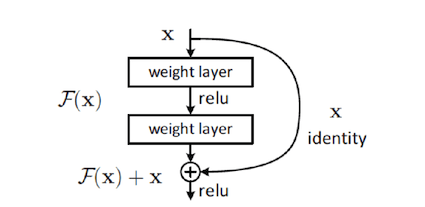

### Residual Block implementation

The ResidualBlock class implements the basic building block of the ResNet50 architecture. It consists of three convolutional layers, each followed by batch normalization and ReLU activation, and a skip connection that adds the input tensor to the output tensor of the third convolutional layer. 

The skip connection is enabled by setting the `identity_downsample` parameter to a function that downsamples the input tensor using an identity operation (i.e., no convolutional layer is applied). Downsampling is a technique used to reduce the spatial dimensions (i.e., height and width) of the input feature maps. This is typically done using pooling layers or convolutional layers with a stride greater than 1.

This function is only used when the spatial dimensions of the input tensor do not match those of the output tensor of the third convolutional layer, and it ensures that the skip connection can be applied even when the number of feature maps changes. 

The `stride` parameter controls the downsampling factor of the second convolutional layer, while intermediate_channels determine the number of feature maps of the first and second convolutional layers. 

The `expansion` parameter determines the number of feature maps of the third convolutional layer, which is four times the number of feature maps of the second convolutional layer.


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(ResidualBlock, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


## ResNet50 implementation

Now that the ResidualBlock has been created, the ResNet50 can be built.

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

## Training

## Intersection Over Union

To assess the goodness of fit of the model, namely how precise the predicted bounding boxes are with respect to the ground truth ones, we use the **Intersection over Union** metric. 

The Intersection over Union (IoU) is a common metric used to evaluate object detection models, which measures the overlap between the predicted bounding box and the ground truth bounding box.

The Jaccard index can measure the similarity between two sets. Given 2 sets A and B, their Jaccard index is the size of their intersection divided by the size of their union:

$$ J(A,B) = \frac{|A \cap B|}{|A \cup B|} = IoU(A,B)$$


 
In fact, we can consider the pixel area of any bounding box as a set of pixels. In this way, we can measure the similarity of the two bounding boxes by the Jaccard index of their pixel sets. 

For two bounding boxes, we usually refer their Jaccard index as intersection over union (IoU), which is the ratio of their intersection area to their union area. 

The range of an IoU is between 0 and 1: 0 means that two bounding boxes do not overlap at all, while 1 indicates that the two bounding boxes are equal.



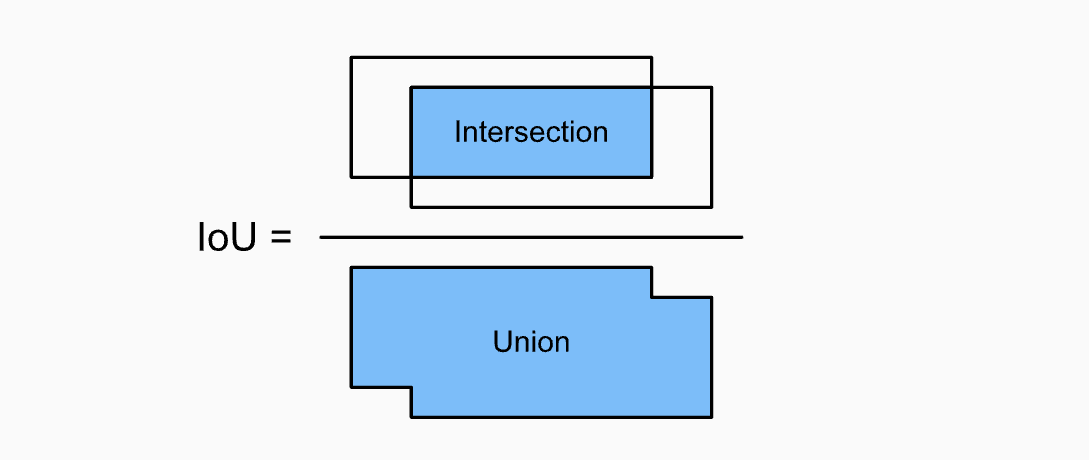

In [ ]:
def bbox_iou(pred_boxes, target_boxes):
    """
    Calculates the Intersection over Union (IoU) of two sets of bounding boxes.
    """
    ious = []
    for b in range(len(pred_boxes)):
        pred_box = pred_boxes[b]
        target_box = target_boxes[b]

        x1_pred, y1_pred, x2_pred, y2_pred = pred_box.unbind(dim=-1)
        x1_target, y1_target, x2_target, y2_target = target_box.unbind(dim=-1)

        xi1 = torch.max(x1_pred, x1_target)
        yi1 = torch.max(y1_pred, y1_target)
        xi2 = torch.min(x2_pred, x2_target)
        yi2 = torch.min(y2_pred, y2_target)

        inter_area = torch.clamp(xi2 - xi1, min=0) * torch.clamp(yi2 - yi1, min=0)
        pred_area = (x2_pred - x1_pred) * (y2_pred - y1_pred)
        target_area = (x2_target - x1_target) * (y2_target - y1_target)
        union_area = pred_area + target_area - inter_area

        iou = inter_area / union_area
        ious.append(iou)

    return torch.stack(ious)


## Smooth L1 Loss

The **smooth L1 loss** is a loss function commonly used in object detection tasks to train neural networks. It is a modification of the standard L1 loss that provides a smooth gradient near the origin, which helps to prevent exploding gradients during training. 

The smooth L1 loss is typically used to calculate the difference between the predicted bounding box coordinates and the ground truth bounding box coordinates. The loss is minimized when the predicted bounding box coordinates match the ground truth coordinates. 

The smooth L1 loss is defined as:

\begin{equation}
    \operatorname{smooth}{L1}(x)=
    \begin{cases}
        0.5 x^2 & \text{if } |x| < 1 \\
        |x| - 0.5 & \text{otherwise}
    \end{cases}
\end{equation}


where $x$ is the difference between the predicted and ground truth bounding box coordinates.



### Hyperparameters

- Epochs number = 20
- Learning rate = 0.001
- Optimizer = Adam optimizer
- Batch size = 16

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define training parameters
num_epochs = 20
learning_rate = 0.001


# Create the model, loss function, and optimizer
model = ResNet(ResidualBlock, [3, 4, 6, 3], image_channels=3).to(device)
loss_fn = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
train_ious = []
val_ious = []

### Training Phase

The training phase shows that the model is improving its performance with each epoch, as seen in the decreasing train and validation losses and the increasing train and validation IoU values. The model seems to converge well, achieving a high validation IoU of 0.7253 at the last epoch, which indicates good generalization ability. 

In [ ]:
for epoch in range(num_epochs):
    # Training loop
    model.train()
    train_loss = 0.0
    train_iou = 0.0
    for images, bboxes in train_data_loader:
        # Move data to GPU if available
        images = images.to(device)
        bboxes = bboxes.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, bboxes)
        train_loss += loss.item()

        # Compute IoU
        iou = bbox_iou(outputs, bboxes)
        train_iou += iou.sum()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_data_loader)
    train_iou /= len(train_data_loader.dataset)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, bboxes in valid_data_loader:
            # Move data to GPU if available
            images = images.to(device)
            bboxes = bboxes.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, bboxes)
            val_loss += loss.item()

            # Compute IoU
            iou = bbox_iou(outputs, bboxes)
            val_iou += iou.sum()

    val_loss /= len(valid_data_loader)
    val_iou /= len(valid_data_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    # Print results
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, "
          f"Val loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")


Epoch [1/20], Train loss: 41.5060, Train IoU: 0.3830, Val loss: 19.8042, Val IoU: 0.5857
Epoch [2/20], Train loss: 18.0003, Train IoU: 0.6330, Val loss: 18.3063, Val IoU: 0.6235
Epoch [3/20], Train loss: 17.3010, Train IoU: 0.6402, Val loss: 17.3040, Val IoU: 0.6352
Epoch [4/20], Train loss: 16.7736, Train IoU: 0.6478, Val loss: 18.1662, Val IoU: 0.6248
Epoch [5/20], Train loss: 16.1154, Train IoU: 0.6568, Val loss: 15.0943, Val IoU: 0.6594
Epoch [6/20], Train loss: 15.5358, Train IoU: 0.6661, Val loss: 14.8475, Val IoU: 0.6733
Epoch [7/20], Train loss: 14.9853, Train IoU: 0.6740, Val loss: 15.0646, Val IoU: 0.6608
Epoch [8/20], Train loss: 14.3460, Train IoU: 0.6852, Val loss: 13.4842, Val IoU: 0.6925
Epoch [9/20], Train loss: 13.3984, Train IoU: 0.7027, Val loss: 13.5157, Val IoU: 0.6882
Epoch [10/20], Train loss: 13.0737, Train IoU: 0.7064, Val loss: 12.7464, Val IoU: 0.7095
Epoch [11/20], Train loss: 12.6290, Train IoU: 0.7138, Val loss: 12.2732, Val IoU: 0.7084
Epoch [12/20], Trai

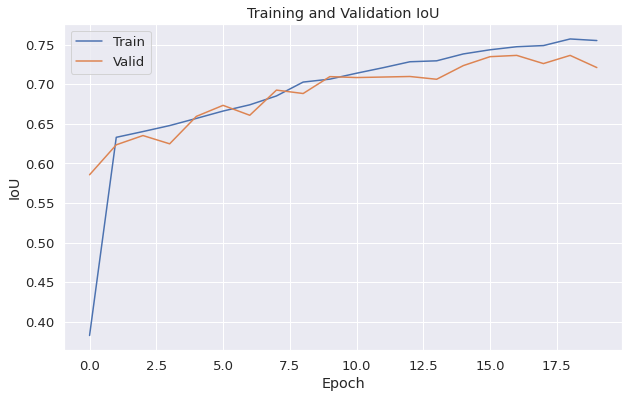

In [ ]:
# Plot IoU
plt.figure(figsize=(10, 6))
plt.plot([t.item() for t in train_ious], label='Train')
plt.plot([t.item() for t in val_ious], label='Valid')
plt.title('Training and Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend(['Train', 'Valid'], loc = "upper left")
plt.show()


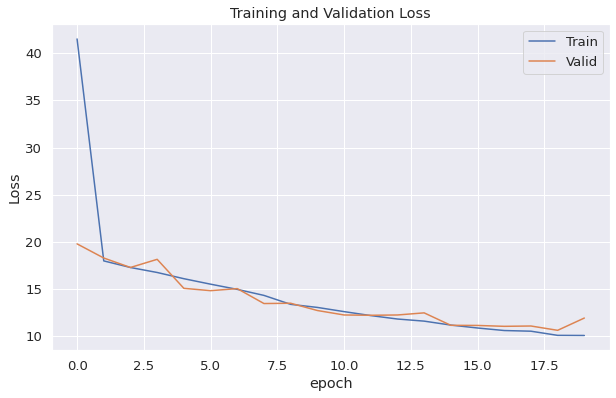

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plot Loss
plt.figure(figsize=(10,6))
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()
plt.savefig('ResNet_Loss.png')

In [ ]:
"""
# Save the model
torch.save(model.state_dict(), 'resnet.pth')
# Load the saved model
model = ResNet(ResidualBlock, [3, 4, 6, 3], image_channels=3).to(device)
if torch.cuda.is_available():
    model.load_state_dict(torch.load('resnet.pth'))
"""

## Predictions on Test Dataset

Here, the predictive performance of the model is evaluated on the test dataset, which has not been used during training or validation. 

This enables to assess the model's generalization ability to unseen data and determine its effectiveness in solving the target problem.

First, the DataLoader for the test dataset is instatiated.

In [ ]:
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)


Here, we create an helper function to draw for each image: 

- In <font color='red'>red</font> the ground truth bounding box
- In <font color='blue'>blue</font> the predicted bounding box 

In [ ]:
def show_image_with_bboxes(image, bboxes_true, bboxes_pred=None, title=None):
    fig, ax = plt.subplots(1, figsize = (14,8))
    ax.imshow(image.permute(1, 2, 0))
    
    for bbox in bboxes_true:
        x1, y1, x2, y2 = bbox.numpy()
        w, h = x2 - x1, y2 - y1
        rect = plt.Rectangle((x1, y1), w, h, fill=False, edgecolor='r', linewidth=2)
        ax.add_patch(rect)
    
    if bboxes_pred is not None:
        for bbox in bboxes_pred:
            x1, y1, x2, y2 = bbox.numpy()
            w, h = x2 - x1, y2 - y1
            rect = plt.Rectangle((x1, y1), w, h, fill=False, edgecolor='b', linewidth=2)
            ax.add_patch(rect)
    
    if title:
        ax.set_title(title)
    
    ax.grid(False)
    plt.show()
    plt.tight_layout()


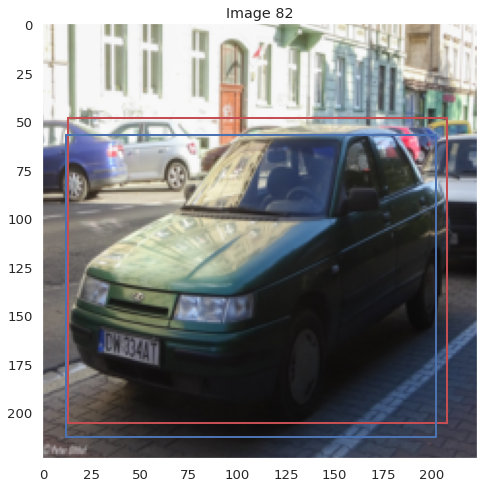

<Figure size 432x288 with 0 Axes>

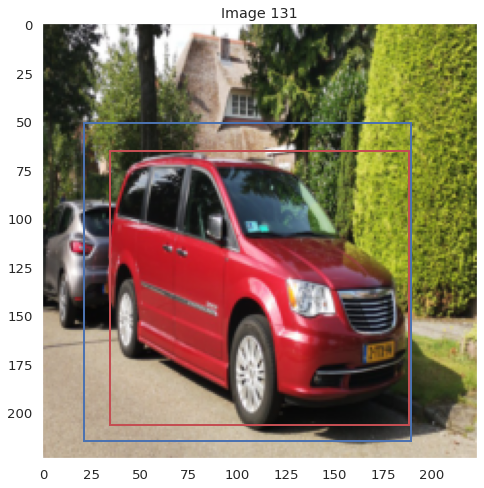

<Figure size 432x288 with 0 Axes>

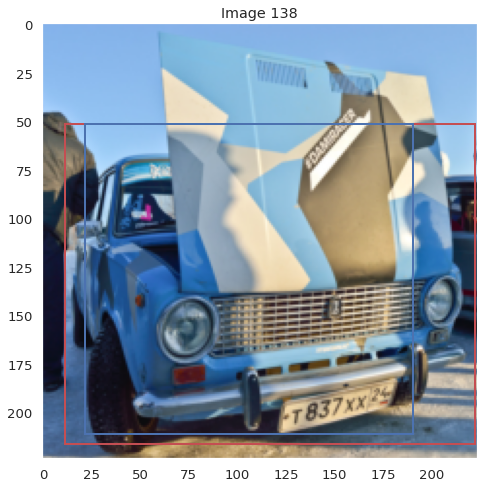

<Figure size 432x288 with 0 Axes>

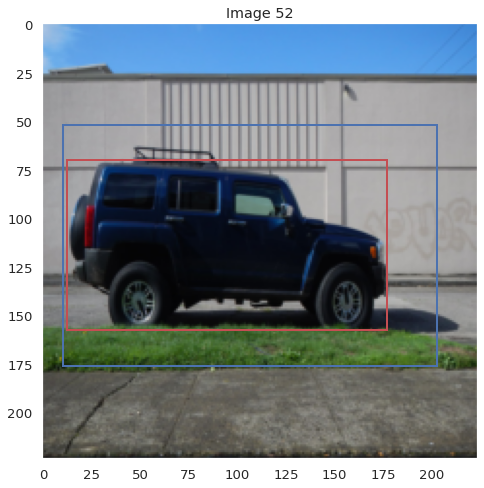

<Figure size 432x288 with 0 Axes>

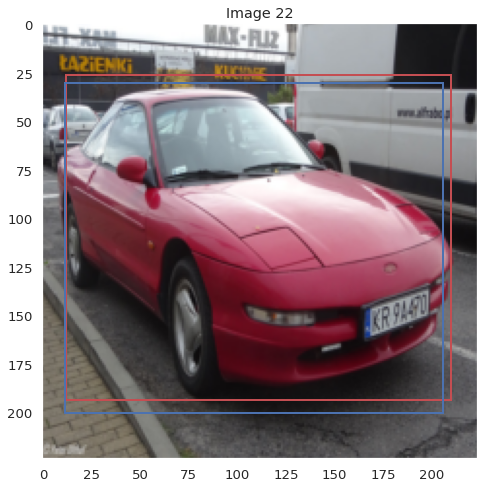

<Figure size 432x288 with 0 Axes>

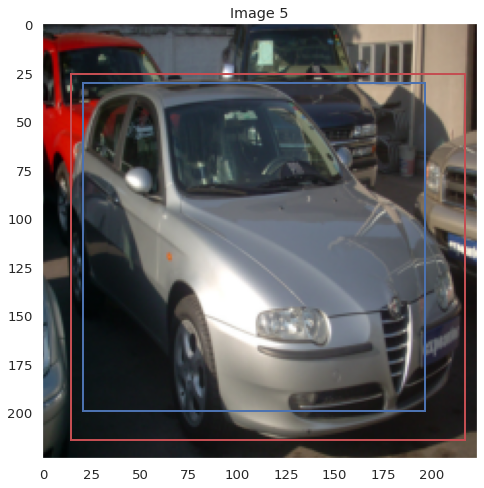

<Figure size 432x288 with 0 Axes>

In [ ]:
# Select a couple of images from the test dataset
np.random.seed(88)
indices = np.random.choice(len(test_dataset), 6, replace=False)
images = [test_dataset[i][0] for i in indices]
bboxes_true = [test_dataset[i][1] for i in indices]

# Make predictions on the selected images
with torch.no_grad():
    bboxes_pred = []
    for image in images:
        image = image.unsqueeze(0).to(device).float()
        output = model(image)
        bboxes_pred.append(output.squeeze().cpu())

# Show the images with the true and predicted bounding boxes
for i in range(len(images)):
    show_image_with_bboxes(images[i], [bboxes_true[i]], [bboxes_pred[i]], f"Image {indices[i]}")


In [ ]:
model.eval()
with torch.no_grad():
    ious = []
    for images, boxes in test_data_loader:
        images = images.to(device)
        boxes = boxes.to(device)
        # Get predictions from the model
        predictions = model(images)

        # Compute IoU for each image in the batch
        iou = bbox_iou(predictions, boxes)
        ious.append(iou.mean())

    # Compute average IoU across all images
    avg_iou = torch.stack(ious).mean()
    print("Average IoU: ", avg_iou.item())




Average IoU:  0.709749903165878


# Conclusions

About the classification task, overall, the model predicts well the class of the vehicles with peaks of 78%, 81% and 72% for the cathegories Helicopter, Motorcycle and Taxi. On the other hand, lower values are observed for Boat and Truck with the accuracies at 21%. 

Concerning object localization, the average IoU of 0.71 achieved on the test dataset leads to the conclusion that the model has performed well in predicting the bounding boxes for the cars in the test images. 




# Next Work

The next step in the object detection project involves integrating the vehicle classification and car detection sections into a cohesive system. Different approaches could be explored for combining the two sections, including a two-stage detection model (Faster R-CNN) or a single-stage model (YOLO)with shared feature extraction. 